# LSTM for Time Series

The dataset source: https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/


In [1]:
!wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv

--2023-02-11 16:28:25--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8000::154, 2606:50c0:8003::154, 2606:50c0:8002::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8000::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2180 (2,1K) [text/plain]
Saving to: ‘airline-passengers.csv.4’

airline-passengers. 100%[===================>]   2,13K  --.-KB/s    in 0s      

2023-02-11 16:28:25 (31,9 MB/s) - ‘airline-passengers.csv.4’ saved [2180/2180]



In [2]:
from sklearn.preprocessing import MinMaxScaler


# Load data
with open("airline-passengers.csv", mode="r") as fp:
    fp.readline()
    data = [[float(line.split(",")[1])] for line in fp.readlines()]


# Scale data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

In [4]:
from neuralogic.core import R


window_size = 4

examples = []
queries = []

for i in range(len(scaled_data) - window_size - 1):
    example = []
    
    for index, value in enumerate(scaled_data[i:i + window_size]):
        example.append(R.x(index + 1)[value[0]])
    examples.append(example)
    queries.append(R.predict[scaled_data[i + window_size][0]])

In [5]:
# Print first three queries and examples
for query, example in zip(queries[:3], examples[:3]):
    print("Query:", query, "Examples:", ", ".join(str(e) for e in example))

Query: 0.03281853281853281 predict. Examples: 0.015444015444015441 x(1)., 0.02702702702702703 x(2)., 0.05405405405405403 x(3)., 0.04826254826254825 x(4).
Query: 0.05984555984555981 predict. Examples: 0.02702702702702703 x(1)., 0.05405405405405403 x(2)., 0.04826254826254825 x(3)., 0.03281853281853281 x(4).
Query: 0.08494208494208491 predict. Examples: 0.05405405405405403 x(1)., 0.04826254826254825 x(2)., 0.03281853281853281 x(3)., 0.05984555984555981 x(4).


In [6]:
train_size = int(len(scaled_data) * 0.70)

train_examples = examples[:train_size]
train_queries = queries[:train_size]

In [7]:
from neuralogic.dataset import Dataset


dataset = Dataset(train_examples, train_queries)

In [8]:
import numpy as np

from neuralogic.core import R, V, Template, Settings
from neuralogic.nn.module import LSTM
import neuralogic.nn.functional as F


template = Template()

dim = 20

# input size, hidden size, output_name, input_name, hidden_input_name, cell_state_0_name
template += LSTM(1, dim, "lstm1_out", "x", "lstm1_h0", "lstm1_c0", arity=0)
template += LSTM(dim, dim, "lstm2_out", "lstm1_out", "lstm2_h0", "lstm1_c0", arity=0)
template += LSTM(dim, dim, "lstm3_out", "lstm2_out", "lstm3_h0", "lstm1_c0", arity=0)

# Linear layer (projection to scalar) + sigmoid
template += (R.predict <= R.lstm3_out(V.X)[1, dim]) | [F.sigmoid]
template += R.predict / 0 | [F.identity]


template += R.lstm1_h0[np.zeros(dim)]
template += R.lstm1_c0[np.zeros(dim)]

template += R.lstm2_h0[np.zeros(dim)]
template += R.lstm2_c0[np.zeros(dim)]

template += R.lstm3_h0[np.zeros(dim)]
template += R.lstm3_c0[np.zeros(dim)]

In [9]:
from neuralogic.nn.loss import MSE
from neuralogic.optim import Adam


settings = Settings(optimizer=Adam(lr=0.001), error_function=MSE())
model = template.build(settings)

built_dataset = model.build_dataset(dataset, progress=True)

Building:   0%|                                                                                               …

In [10]:
epochs = 300

losses = []

for epoch in range(epochs):
    res, sample_count = model(built_dataset.samples, train=True)

    acc_loss = 0
    
    for target, output, loss in res:
        acc_loss += loss
        
    print("Epoch", epoch, "Loss:", acc_loss, "Mean loss:", acc_loss / sample_count)
    losses.append(acc_loss)

Epoch 0 Loss: 5.715762719156138 Mean loss: 0.05715762719156138
Epoch 1 Loss: 2.9277588745454284 Mean loss: 0.029277588745454285
Epoch 2 Loss: 1.7611229763634915 Mean loss: 0.017611229763634915
Epoch 3 Loss: 1.3051838788499823 Mean loss: 0.013051838788499824
Epoch 4 Loss: 1.1662684966567458 Mean loss: 0.011662684966567458
Epoch 5 Loss: 1.0855330067647546 Mean loss: 0.010855330067647545
Epoch 6 Loss: 1.0328900527402585 Mean loss: 0.010328900527402585
Epoch 7 Loss: 0.9959791472418418 Mean loss: 0.009959791472418418
Epoch 8 Loss: 0.9673639566131574 Mean loss: 0.009673639566131575
Epoch 9 Loss: 0.943190286218842 Mean loss: 0.00943190286218842
Epoch 10 Loss: 0.9214379508033702 Mean loss: 0.009214379508033702
Epoch 11 Loss: 0.9009343752858782 Mean loss: 0.009009343752858782
Epoch 12 Loss: 0.8807454481776903 Mean loss: 0.008807454481776902
Epoch 13 Loss: 0.859680635661283 Mean loss: 0.00859680635661283
Epoch 14 Loss: 0.8356006684848919 Mean loss: 0.00835600668484892
Epoch 15 Loss: 0.8046631387

Epoch 134 Loss: 0.17759167189052794 Mean loss: 0.0017759167189052793
Epoch 135 Loss: 0.17644053981762586 Mean loss: 0.0017644053981762586
Epoch 136 Loss: 0.17526154450490783 Mean loss: 0.0017526154450490782
Epoch 137 Loss: 0.17413095922905666 Mean loss: 0.0017413095922905665
Epoch 138 Loss: 0.17312538813821396 Mean loss: 0.0017312538813821397
Epoch 139 Loss: 0.17228097052651925 Mean loss: 0.0017228097052651924
Epoch 140 Loss: 0.17157358319005347 Mean loss: 0.0017157358319005347
Epoch 141 Loss: 0.17094400200536386 Mean loss: 0.0017094400200536387
Epoch 142 Loss: 0.17033847752046316 Mean loss: 0.0017033847752046317
Epoch 143 Loss: 0.16972759209255095 Mean loss: 0.0016972759209255095
Epoch 144 Loss: 0.16910260939603503 Mean loss: 0.0016910260939603503
Epoch 145 Loss: 0.16846511472376482 Mean loss: 0.0016846511472376482
Epoch 146 Loss: 0.16781930253814165 Mean loss: 0.0016781930253814165
Epoch 147 Loss: 0.16716849950688698 Mean loss: 0.0016716849950688699
Epoch 148 Loss: 0.1665144714670442

Epoch 258 Loss: 0.2386396544888986 Mean loss: 0.0023863965448889858
Epoch 259 Loss: 0.31201955073719995 Mean loss: 0.0031201955073719995
Epoch 260 Loss: 0.16216760835810654 Mean loss: 0.0016216760835810653
Epoch 261 Loss: 0.16648864338415775 Mean loss: 0.0016648864338415774
Epoch 262 Loss: 0.15540133652128238 Mean loss: 0.0015540133652128239
Epoch 263 Loss: 0.1493506538961854 Mean loss: 0.001493506538961854
Epoch 264 Loss: 0.139459332727619 Mean loss: 0.00139459332727619
Epoch 265 Loss: 0.1334717124180713 Mean loss: 0.0013347171241807128
Epoch 266 Loss: 0.11855875458958151 Mean loss: 0.0011855875458958152
Epoch 267 Loss: 0.11435600589535014 Mean loss: 0.0011435600589535014
Epoch 268 Loss: 0.1123635784064095 Mean loss: 0.001123635784064095
Epoch 269 Loss: 0.11118093040935359 Mean loss: 0.001111809304093536
Epoch 270 Loss: 0.11083272283506919 Mean loss: 0.001108327228350692
Epoch 271 Loss: 0.11096433694544319 Mean loss: 0.001109643369454432
Epoch 272 Loss: 0.11124282560667885 Mean loss: 

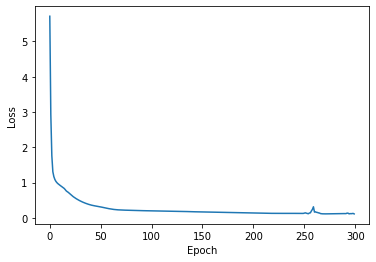

In [11]:
import matplotlib.pyplot as plt


plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.plot(losses)

In [12]:
test_queries = [R.predict for _ in examples]
test_dataset = Dataset(examples, test_queries)

test_build_dataset = model.build_dataset(test_dataset)


predictions = []

for y_hat in model(test_build_dataset.samples, train=False):
    predictions.append([y_hat])

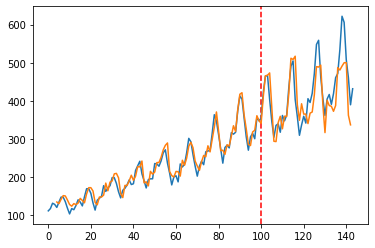

In [13]:
plt.axvline(x=train_size, c='r', linestyle='--')


shifted_predictions = [[np.nan] for _ in range(window_size)]
shifted_predictions.extend(predictions)

plt.plot(scaler.inverse_transform(scaled_data))
plt.plot(scaler.inverse_transform(shifted_predictions))


plt.show()